In [6]:
!pip install matplotlib


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"
!tesseract --version

'tesseract' is not recognized as an internal or external command,
operable program or batch file.


Memulai proses dari folder: 'C:\Users\LENOVO\Downloads\statexplore\Data\C01\business_confidence_index and manufacturing_pmi'
🚀 Menjalankan dalam MODE PRODUKSI. Memproses 25 file...

[INFO] Memproses business_confidence_index and manufacturing_pmi tahun 2000.png...
  -> Sumbu Y (OCR): Min=5.0, Max=55.0

[INFO] Memproses business_confidence_index and manufacturing_pmi tahun 2001.png...
  -> Sumbu Y (OCR): Min=5.0, Max=475.0

[INFO] Memproses business_confidence_index and manufacturing_pmi tahun 2002.png...
  -> Sumbu Y (OCR): Min=3.0, Max=55.0

[INFO] Memproses business_confidence_index and manufacturing_pmi tahun 2003.png...
  -> Sumbu Y (OCR): Min=40.0, Max=55.0

[INFO] Memproses business_confidence_index and manufacturing_pmi tahun 2004.png...
  -> Sumbu Y (OCR): Min=5.0, Max=55.0

[INFO] Memproses business_confidence_index and manufacturing_pmi tahun 2005.png...
  -> Sumbu Y (OCR): Min=4.0, Max=55.0

[INFO] Memproses business_confidence_index and manufacturing_pmi tahun 2006.png...
 

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15892\29845168.py:87: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  proc_df.interpolate(method='time', inplace=True)


  -> Fitur Moving Average 30 hari (MA30) ditambahkan.


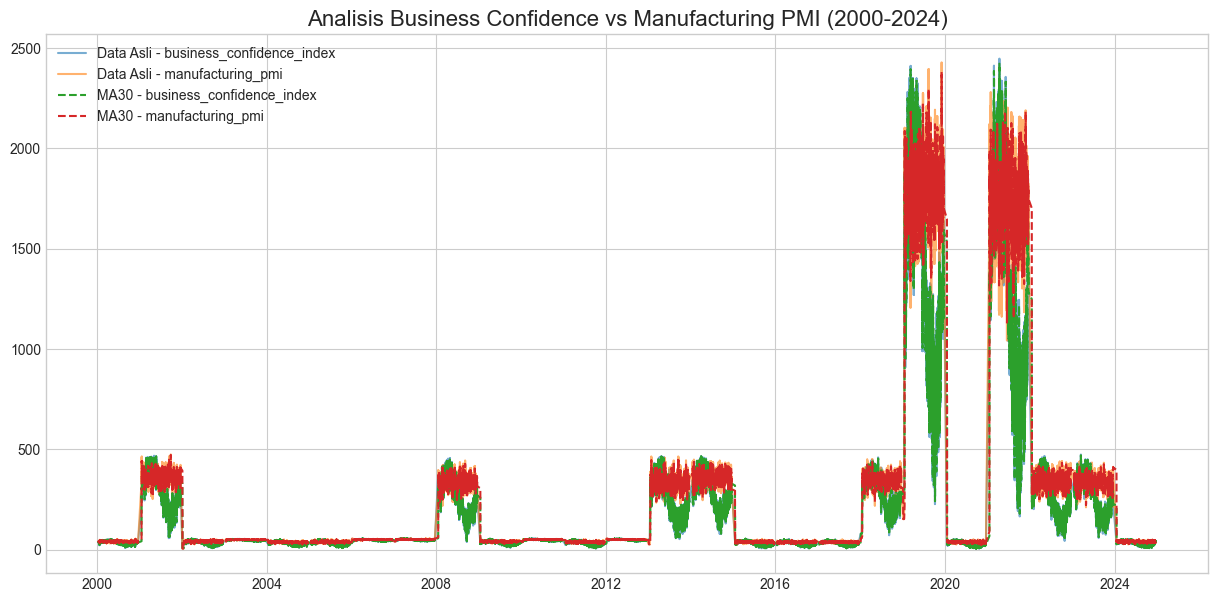


✅ SUKSES! 818281 baris data telah dianalisis dan disimpan ke business_confidence_index_and_manufacturing_pmi_2000-2024_complete.csv


In [8]:
import cv2
import numpy as np
import pandas as pd
import re
import os
import matplotlib.pyplot as plt
import pytesseract

# --- PENGATURAN UTAMA ---

# ⚙️ Set DEBUG_MODE ke False untuk memproses SEMUA file (2000-2024)
DEBUG_MODE = False

# 1. Sesuaikan path ke tesseract jika perlu (untuk Windows)
# pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

# 2. Sesuaikan path ke folder data Anda
folder_path = r"C:\Users\LENOVO\Downloads\statexplore\Data\C01\business_confidence_index and manufacturing_pmi"

# 3. Sesuaikan nama file output CSV
output_csv_file = "business_confidence_index_and_manufacturing_pmi_2000-2024_complete.csv"

# 4. Nilai FALLBACK jika OCR gagal (disesuaikan dari gambar contoh)
FALLBACK_Y_MIN, FALLBACK_Y_MAX = 35, 60

# 5. Rentang warna HSV
var1_name = "business_confidence_index" # Biru
lower_blue = np.array([90, 80, 50])
upper_blue = np.array([130, 255, 255])

var2_name = "manufacturing_pmi" # Oranye-Coklat
lower_orange = np.array([10, 80, 80])
upper_orange = np.array([25, 255, 255])


# ------------------- FUNGSI-FUNGSI BANTU -------------------
def preprocess_for_ocr(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)
    return cv2.resize(thresh, None, fx=1.5, fy=1.5, interpolation=cv2.INTER_CUBIC)

def extract_year_from_title(title_crop):
    try:
        title_text = pytesseract.image_to_string(title_crop)
        match = re.search(r'\b(20\d{2})\b', title_text)
        if match: return int(match.group(1))
    except: pass
    return None

def extract_yaxis_range(yaxis_crop):
    try:
        processed_yaxis = preprocess_for_ocr(yaxis_crop)
        ocr_text = pytesseract.image_to_string(processed_yaxis, config='--psm 6')
        numbers = [float(num) for num in re.findall(r'(\d+\.?\d*)', ocr_text)]
        if numbers and len(numbers) > 1: return min(numbers), max(numbers), processed_yaxis
    except: pass
    return None, None, None

# ✨ (MODIFIKASI) Fungsi extract_series sekarang menerima parameter hasil OCR untuk disimpan
def extract_series(mask, var_name, plot_h, plot_w, year, y_min, y_max, ocr_results):
    extracted = []
    for x_pixel in range(plot_w):
        y_pixels = np.where(mask[:, x_pixel] > 0)[0]
        if len(y_pixels) > 0:
            y_pixel_avg = int(np.mean(y_pixels))
            value = y_max - ((y_pixel_avg / plot_h) * (y_max - y_min))
            day_of_year = int((x_pixel / plot_w) * 365) + 1
            
            # Buat dictionary data dasar
            data_point = {
                "Year": year,
                "DayOfYear": day_of_year,
                var_name: round(value, 2)
            }
            # Tambahkan hasil OCR ke setiap titik data
            data_point.update(ocr_results)
            extracted.append(data_point)
            
    return extracted

def process_and_visualize_data(df, title="Hasil Ekstraksi Data"):
    # Fungsi ini tidak berubah
    print("\n[ANALISIS] Memulai pemrosesan data yang diekstrak...")
    proc_df = df.copy()
    proc_df['Date'] = pd.to_datetime(proc_df['Year'].astype(str) + '-' + proc_df['DayOfYear'].astype(str), format='%Y-%j')
    proc_df = proc_df.sort_values(by='Date').set_index('Date')
    proc_df.interpolate(method='time', inplace=True)
    proc_df.dropna(inplace=True)
    for col in [var1_name, var2_name]:
        if col in proc_df.columns:
            proc_df[f'{col}_MA30'] = proc_df[col].rolling(window=30).mean()
    print("  -> Fitur Moving Average 30 hari (MA30) ditambahkan.")
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(15, 7))
    if var1_name in proc_df.columns: ax.plot(proc_df.index, proc_df[var1_name], label=f'Data Asli - {var1_name}', alpha=0.6)
    if var2_name in proc_df.columns: ax.plot(proc_df.index, proc_df[var2_name], label=f'Data Asli - {var2_name}', alpha=0.6)
    if f'{var1_name}_MA30' in proc_df.columns: ax.plot(proc_df.index, proc_df[f'{var1_name}_MA30'], label=f'MA30 - {var1_name}', linestyle='--')
    if f'{var2_name}_MA30' in proc_df.columns: ax.plot(proc_df.index, proc_df[f'{var2_name}_MA30'], label=f'MA30 - {var2_name}', linestyle='--')
    ax.set_title(title, fontsize=16)
    ax.legend()
    plt.show()
    return proc_df

# ------------------- KODE UTAMA -------------------
def main():
    print(f"Memulai proses dari folder: '{folder_path}'")
    try:
        image_files = sorted([f for f in os.listdir(folder_path) if f.endswith(".png")])
    except FileNotFoundError:
        print(f"❌ KESALAHAN: Folder tidak ditemukan di '{folder_path}'.")
        return
    
    if not image_files:
        print(f"❌ KESALAHAN: Tidak ada file .png ditemukan di '{folder_path}'.")
        return

    all_points = []
    files_to_process = image_files[:1] if DEBUG_MODE else image_files
    if DEBUG_MODE:
        print("🛠️ Menjalankan dalam MODE DEBUG.")
    else:
        print(f"🚀 Menjalankan dalam MODE PRODUKSI. Memproses {len(files_to_process)} file...")

    for filename in files_to_process:
        full_path = os.path.join(folder_path, filename)
        img = cv2.imread(full_path)
        if img is None: continue
        
        h, w, _ = img.shape
        print(f"\n[INFO] Memproses {filename}...")

        title_crop = img[0:int(h*0.1), 0:w]
        yaxis_crop = img[int(h*0.12):int(h*0.9), 0:int(w*0.06)]

        year_ocr = extract_year_from_title(title_crop)
        year_from_file = int(re.search(r'(\d{4})', filename).group(1)) if re.search(r'(\d{4})', filename) else 0
        year = year_ocr if year_ocr else year_from_file
        
        y_min_ocr, y_max_ocr, _ = extract_yaxis_range(yaxis_crop)
        
        # ✨ (MODIFIKASI) Tentukan metode dan nilai Y yang akan digunakan
        if y_min_ocr is not None and y_max_ocr is not None:
            y_min, y_max = y_min_ocr, y_max_ocr
            yaxis_method = "OCR"
            print(f"  -> Sumbu Y (OCR): Min={y_min}, Max={y_max}")
        else:
            y_min, y_max = FALLBACK_Y_MIN, FALLBACK_Y_MAX
            yaxis_method = "Fallback"
            print(f"  -> Sumbu Y (Fallback): Min={y_min}, Max={y_max}")

        # ✨ (MODIFIKASI) Siapkan dictionary hasil OCR untuk disimpan
        ocr_results_to_save = {
            'YearOCR': year_ocr if year_ocr else '',
            'YMinOCR': y_min_ocr if y_min_ocr else '',
            'YMaxOCR': y_max_ocr if y_max_ocr else '',
            'YAxisMethod': yaxis_method
        }

        plot_area = img[int(h*0.12):int(h*0.9), int(w*0.05):int(w*0.98)]
        plot_h, plot_w, _ = plot_area.shape
        hsv = cv2.cvtColor(plot_area, cv2.COLOR_BGR2HSV)
        
        mask_blue = cv2.inRange(hsv, lower_blue, upper_blue)
        mask_orange = cv2.inRange(hsv, lower_orange, upper_orange)
        
        data_var1 = extract_series(mask_blue, var1_name, plot_h, plot_w, year, y_min, y_max, ocr_results_to_save)
        data_var2 = extract_series(mask_orange, var2_name, plot_h, plot_w, year, y_min, y_max, ocr_results_to_save)
        
        df1 = pd.DataFrame(data_var1)
        df2 = pd.DataFrame(data_var2)

        if not df1.empty or not df2.empty:
            if not df1.empty and not df2.empty:
                # Gabungkan berdasarkan kolom non-nilai, termasuk kolom OCR baru
                merge_cols = ['Year', 'DayOfYear'] + list(ocr_results_to_save.keys())
                all_points.append(pd.merge(df1, df2, on=merge_cols, how="outer"))
            elif not df1.empty:
                all_points.append(df1)
            else:
                all_points.append(df2)

    if all_points:
        raw_df = pd.concat(all_points, ignore_index=True)
        analyzed_df = process_and_visualize_data(raw_df, title="Analisis Business Confidence vs Manufacturing PMI (2000-2024)")
        
        # Susun ulang kolom agar lebih rapi
        value_cols = [var1_name, var2_name, f'{var1_name}_MA30', f'{var2_name}_MA30']
        id_cols = ['Year', 'DayOfYear']
        ocr_cols = ['YearOCR', 'YMinOCR', 'YMaxOCR', 'YAxisMethod']
        
        # Filter kolom yang ada di DataFrame
        final_cols_order = [col for col in id_cols + value_cols + ocr_cols if col in analyzed_df.columns]
        analyzed_df = analyzed_df.reset_index() # Kembalikan 'Date' dari index
        final_cols_order.insert(0, 'Date') # Tambahkan Date di awal
        
        final_df_to_save = analyzed_df[final_cols_order]

        final_df_to_save.to_csv(output_csv_file, index=False)
        print(f"\n✅ SUKSES! {len(final_df_to_save)} baris data telah dianalisis dan disimpan ke {output_csv_file}")
    elif not DEBUG_MODE:
        print("\n⚠️ PROSES SELESAI: Tidak ada data yang berhasil diekstrak.")

if __name__ == '__main__':
    main()

Memulai proses dari folder: 'C:\Users\LENOVO\Downloads\statexplore\Data\C01\business_confidence_index and manufacturing_pmi'
🚀 Memproses 25 file...

[INFO] Memproses business_confidence_index and manufacturing_pmi tahun 2000.png...


  -> Sumbu Y (OCR): Min=7.0, Max=55.0

[INFO] Memproses business_confidence_index and manufacturing_pmi tahun 2001.png...
  -> Sumbu Y (OCR): Min=4.0, Max=475.0

[INFO] Memproses business_confidence_index and manufacturing_pmi tahun 2002.png...
  -> Sumbu Y (OCR): Min=40.0, Max=3475.0

[INFO] Memproses business_confidence_index and manufacturing_pmi tahun 2003.png...
  -> Sumbu Y (OCR): Min=3.0, Max=55.0

[INFO] Memproses business_confidence_index and manufacturing_pmi tahun 2004.png...
  -> Sumbu Y (OCR): Min=7.0, Max=55.0

[INFO] Memproses business_confidence_index and manufacturing_pmi tahun 2005.png...
  -> Sumbu Y (OCR): Min=3.0, Max=475.0

[INFO] Memproses business_confidence_index and manufacturing_pmi tahun 2006.png...
  -> Sumbu Y (OCR): Min=4.0, Max=55.0

[INFO] Memproses business_confidence_index and manufacturing_pmi tahun 2007.png...
  -> Sumbu Y (OCR): Min=42.5, Max=57.5

[INFO] Memproses business_confidence_index and manufacturing_pmi tahun 2008.png...
  -> Sumbu Y (OCR)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15892\859933935.py:99: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  proc_df.interpolate(method='time', inplace=True)
C:\Users\LENOVO\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


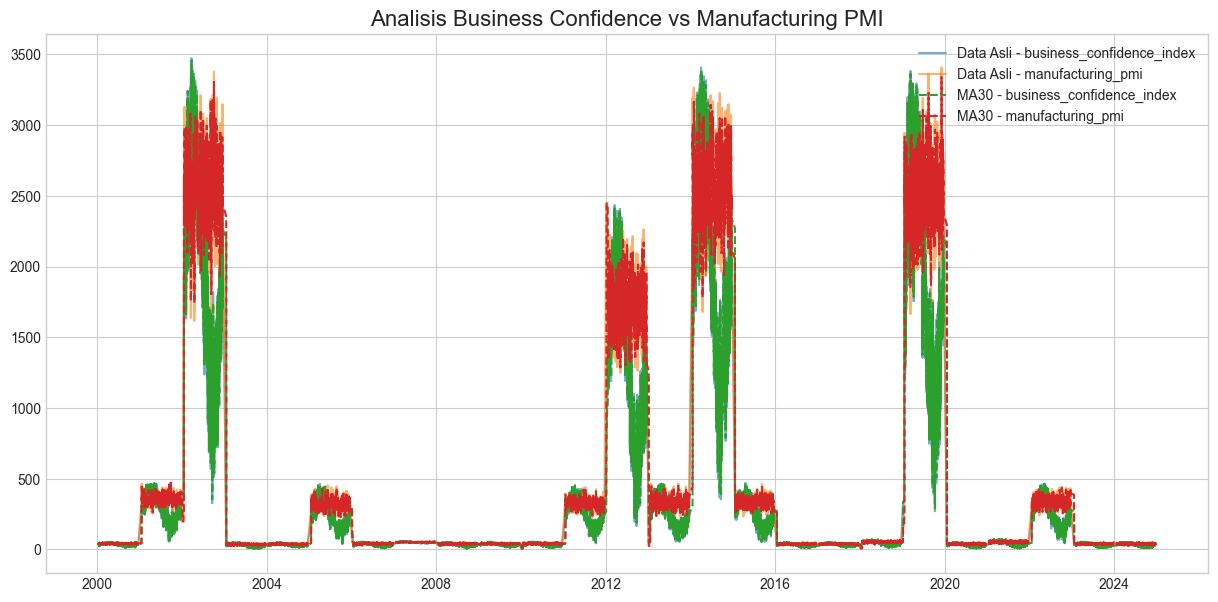


✅ SUKSES! 808686 baris data disimpan ke business_confidence_index_and_manufacturing_pmi_2000-2024_high_accuracy.csv


In [9]:
import cv2
import numpy as np
import pandas as pd
import re
import os
import matplotlib.pyplot as plt
import pytesseract

# --- PENGATURAN UTAMA ---

DEBUG_MODE = False
folder_path = r"C:\Users\LENOVO\Downloads\statexplore\Data\C01\business_confidence_index and manufacturing_pmi"
output_csv_file = "business_confidence_index_and_manufacturing_pmi_2000-2024_high_accuracy.csv"
FALLBACK_Y_MIN, FALLBACK_Y_MAX = 35, 60
var1_name = "business_confidence_index"
lower_blue = np.array([90, 80, 50])
upper_blue = np.array([130, 255, 255])
var2_name = "manufacturing_pmi"
lower_orange = np.array([10, 80, 80])
upper_orange = np.array([25, 255, 255])

# ------------------- FUNGSI-FUNGSI BANTU (DENGAN PENINGKATAN) -------------------

# ✨ (DISEMPURNAKAN) Preprocessing OCR kini menggunakan Adaptive Thresholding
def preprocess_for_ocr(image):
    """
    Membersihkan gambar untuk OCR dengan metode yang lebih canggih.
    Adaptive thresholding lebih baik untuk kondisi pencahayaan yang tidak merata.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Terapkan sedikit blur untuk mengurangi noise sebelum thresholding
    blurred = cv2.GaussianBlur(gray, (3, 3), 0)
    # Adaptive thresholding bekerja lebih baik daripada threshold global
    thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 4)
    return cv2.resize(thresh, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)

# ✨ (BARU) Fungsi untuk membersihkan noise pada mask warna
def clean_mask(mask):
    """
    Menggunakan morphological opening untuk menghapus noise (bintik-bintik kecil) dari mask.
    Ini seperti 'menyapu debu' dari hasil deteksi warna.
    """
    kernel = np.ones((3, 3), np.uint8)
    # MORPH_OPEN adalah erosi diikuti oleh dilasi, efektif menghilangkan noise kecil
    cleaned_mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
    return cleaned_mask

def is_leap(year):
    """Mengecek apakah suatu tahun adalah tahun kabisat."""
    return year % 4 == 0 and (year % 100 != 0 or year % 400 == 0)

def extract_year_from_title(title_crop):
    # (Fungsi ini tidak berubah)
    try:
        title_text = pytesseract.image_to_string(title_crop)
        match = re.search(r'\b(20\d{2})\b', title_text)
        if match: return int(match.group(1))
    except: pass
    return None

def extract_yaxis_range(yaxis_crop):
    # (Fungsi ini tidak berubah, namun akan menerima hasil yang lebih baik dari preprocess_for_ocr)
    try:
        processed_yaxis = preprocess_for_ocr(yaxis_crop)
        ocr_text = pytesseract.image_to_string(processed_yaxis, config='--psm 6')
        numbers = [float(num) for num in re.findall(r'(\d+\.?\d*)', ocr_text)]
        if numbers and len(numbers) > 1: return min(numbers), max(numbers), processed_yaxis
    except: pass
    return None, None, None

# ✨ (DISEMPURNAKAN) Fungsi extract_series kini lebih akurat
def extract_series(mask, var_name, plot_h, plot_w, year, y_min, y_max, ocr_results):
    extracted = []
    # Menggunakan mask yang sudah dibersihkan dari noise
    cleaned_mask = clean_mask(mask)
    # Menentukan jumlah hari dalam setahun untuk akurasi sumbu X
    days_in_year = 366 if is_leap(year) else 365

    for x_pixel in range(plot_w):
        y_pixels = np.where(cleaned_mask[:, x_pixel] > 0)[0]
        if len(y_pixels) > 0:
            # Menggunakan median untuk menemukan pusat garis, lebih tahan terhadap noise
            y_pixel_center = int(np.median(y_pixels))
            value = y_max - ((y_pixel_center / plot_h) * (y_max - y_min))
            day_of_year = int((x_pixel / plot_w) * days_in_year) + 1
            
            data_point = {"Year": year, "DayOfYear": day_of_year, var_name: round(value, 2)}
            data_point.update(ocr_results)
            extracted.append(data_point)
            
    return extracted

def process_and_visualize_data(df, title="Hasil Ekstraksi Data"):
    # (Fungsi ini tidak berubah)
    print("\n[ANALISIS] Memulai pemrosesan data...")
    proc_df = df.copy()
    proc_df['Date'] = pd.to_datetime(proc_df['Year'].astype(str) + '-' + proc_df['DayOfYear'].astype(str), format='%Y-%j', errors='coerce')
    proc_df = proc_df.sort_values(by='Date').set_index('Date')
    proc_df.interpolate(method='time', inplace=True)
    proc_df.dropna(inplace=True)
    for col in [var1_name, var2_name]:
        if col in proc_df.columns: proc_df[f'{col}_MA30'] = proc_df[col].rolling(window=30).mean()
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(15, 7))
    if var1_name in proc_df.columns: ax.plot(proc_df.index, proc_df[var1_name], label=f'Data Asli - {var1_name}', alpha=0.6)
    if var2_name in proc_df.columns: ax.plot(proc_df.index, proc_df[var2_name], label=f'Data Asli - {var2_name}', alpha=0.6)
    if f'{var1_name}_MA30' in proc_df.columns: ax.plot(proc_df.index, proc_df[f'{var1_name}_MA30'], label=f'MA30 - {var1_name}', linestyle='--')
    if f'{var2_name}_MA30' in proc_df.columns: ax.plot(proc_df.index, proc_df[f'{var2_name}_MA30'], label=f'MA30 - {var2_name}', linestyle='--')
    ax.set_title(title, fontsize=16)
    ax.legend()
    plt.show()
    return proc_df

# ------------------- KODE UTAMA (Logika sama, namun memanggil fungsi yang disempurnakan) -------------------
def main():
    print(f"Memulai proses dari folder: '{folder_path}'")
    try:
        image_files = sorted([f for f in os.listdir(folder_path) if f.endswith(".png")])
    except FileNotFoundError:
        print(f"❌ KESALAHAN: Folder tidak ditemukan di '{folder_path}'.")
        return
    
    if not image_files:
        print(f"❌ KESALAHAN: Tidak ada file .png ditemukan.")
        return

    all_points = []
    files_to_process = image_files[:1] if DEBUG_MODE else image_files
    print(f"🚀 Memproses {len(files_to_process)} file...")

    for filename in files_to_process:
        full_path = os.path.join(folder_path, filename)
        img = cv2.imread(full_path)
        if img is None: continue
        
        h, w, _ = img.shape
        print(f"\n[INFO] Memproses {filename}...")

        title_crop = img[0:int(h*0.1), 0:w]
        yaxis_crop = img[int(h*0.12):int(h*0.9), 0:int(w*0.06)]

        year_ocr = extract_year_from_title(title_crop)
        year_from_file = int(re.search(r'(\d{4})', filename).group(1)) if re.search(r'(\d{4})', filename) else 0
        year = year_ocr if year_ocr else year_from_file
        
        y_min_ocr, y_max_ocr, _ = extract_yaxis_range(yaxis_crop)
        
        if y_min_ocr is not None and y_max_ocr is not None:
            y_min, y_max, yaxis_method = y_min_ocr, y_max_ocr, "OCR"
            print(f"  -> Sumbu Y (OCR): Min={y_min}, Max={y_max}")
        else:
            y_min, y_max, yaxis_method = FALLBACK_Y_MIN, FALLBACK_Y_MAX, "Fallback"
            print(f"  -> Sumbu Y (Fallback): Min={y_min}, Max={y_max}")

        ocr_results_to_save = {
            'YearOCR': year_ocr or '', 'YMinOCR': y_min_ocr or '',
            'YMaxOCR': y_max_ocr or '', 'YAxisMethod': yaxis_method
        }

        plot_area = img[int(h*0.12):int(h*0.9), int(w*0.05):int(w*0.98)]
        plot_h, plot_w, _ = plot_area.shape
        hsv = cv2.cvtColor(plot_area, cv2.COLOR_BGR2HSV)
        
        mask_blue = cv2.inRange(hsv, lower_blue, upper_blue)
        mask_orange = cv2.inRange(hsv, lower_orange, upper_orange)
        
        data_var1 = extract_series(mask_blue, var1_name, plot_h, plot_w, year, y_min, y_max, ocr_results_to_save)
        data_var2 = extract_series(mask_orange, var2_name, plot_h, plot_w, year, y_min, y_max, ocr_results_to_save)
        
        df1 = pd.DataFrame(data_var1)
        df2 = pd.DataFrame(data_var2)

        if not df1.empty or not df2.empty:
            merge_cols = ['Year', 'DayOfYear'] + list(ocr_results_to_save.keys())
            if not df1.empty and not df2.empty:
                all_points.append(pd.merge(df1, df2, on=merge_cols, how="outer"))
            elif not df1.empty: all_points.append(df1)
            else: all_points.append(df2)

    if all_points:
        raw_df = pd.concat(all_points, ignore_index=True)
        analyzed_df = process_and_visualize_data(raw_df, title="Analisis Business Confidence vs Manufacturing PMI")
        
        analyzed_df = analyzed_df.reset_index()
        value_cols = [var1_name, var2_name, f'{var1_name}_MA30', f'{var2_name}_MA30']
        id_cols = ['Date', 'Year', 'DayOfYear']
        ocr_cols = ['YearOCR', 'YMinOCR', 'YMaxOCR', 'YAxisMethod']
        final_cols_order = [col for col in id_cols + value_cols + ocr_cols if col in analyzed_df.columns]
        
        final_df_to_save = analyzed_df[final_cols_order]
        final_df_to_save.to_csv(output_csv_file, index=False)
        print(f"\n✅ SUKSES! {len(final_df_to_save)} baris data disimpan ke {output_csv_file}")
    else:
        print("\n⚠️ PROSES SELESAI: Tidak ada data yang berhasil diekstrak.")

if __name__ == '__main__':
    main()